## End member mixing analysis (EMMA) to determine streamflow source contributions

### EMMA Step #3: solving EMM models using SciPy sequential least squares quadratic optimization.​

#### This analysis starts from solute data from Wade Brook late winter/early spring flow events captured with ISCOs. Data include:
- base cations from ICP-OES measurements: Al, Ca, Cu, Fe, K, Mg, Mn, Na, P, Zn, Si
- base anions from IC measurements: Cl, F, Br (NO2, NO3, SO4 also from IC - I reject the PO4 from IC)
- nutrient concentrations from total elemental analyzer: SO4, NO3, PO4, DIN
- total organic carbon (TOC) from total elemental analyzer
- stable water isotopes (dD, d18O)

Data are all in the Winter Watershed OneDrive directory under Documents\Link to LCBP Data (Sharepoint)/LCBP_EMMA

- For Hungerford and Wade 2023 timeseries, 17 parameters total
- For Hungerford, 5 were found to be relatively conservative: dD, Ca, Na, d18O, and Mg
- See EMMA Step #1 ["bivariates" notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Wade_2023_ISCO_bivariates.ipynb) and EMMA Step #2 [PCA notebook](https://github.com/MeganEDuffy/EMMA/blob/main/EMMA/Wade_2023_ISCO_PCA.ipynb) for the above work and figures. 
- This is a standalone script, it builds on EMMA Steps #1 and #2 but is run from the original data.

This code utilizes the minimize function from SciPy to find fractions that meet the specified constraints. The objective function minimizes the difference between the observed and predicted observations, subject to the constraints on the fractions.

### TO DO (last updated 2025-04-15):

- [ ] Adaptive endmember read in for event and site within single origin CSV
        - Function to read in EMs, normalize and do PCA, then EMMA and fractional cont balance
- [ ] Maybe use a [stacked line plot](https://stackoverflow.com/questions/2225995/how-can-i-create-stacked-line-graph) instead, sort of like Fuss et al.
- [x] Add snowpak depth and rainfall optional subplot
- [ ] Replace Mt Mansfield snowpack depth data with CoCoRaHS VT-FR-30 data
- [ ] Increase timestep for interpolation

In [1]:
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

## Event AB: February rain

Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].


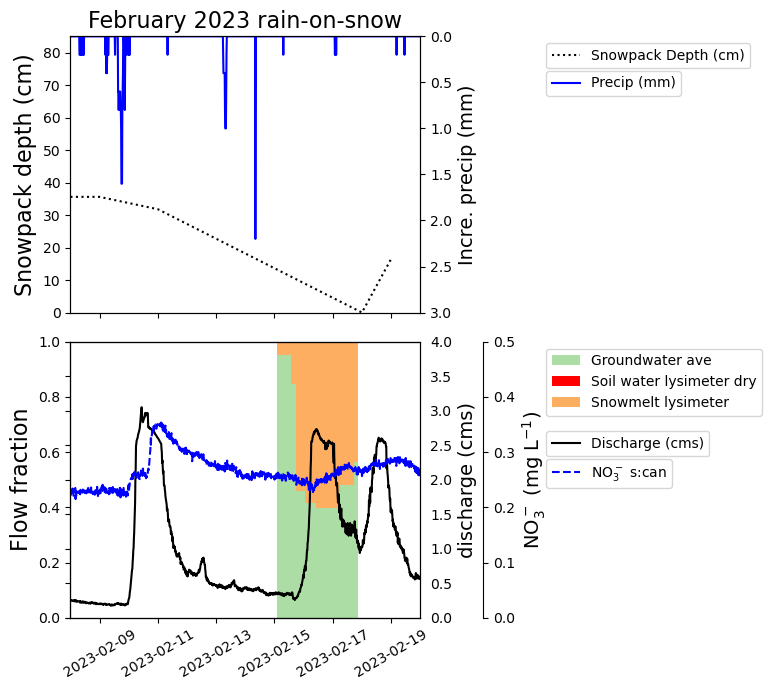

In [2]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
Month = 'February'
#Month = 'March'
#Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave

# Load q and s::can NO3 + TP data from csv
scan_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)

# Load soil temperature data from csv
soil_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/EMMA/data/soil-sensor/Temperature.SoilTemp_15cm@HD_pit1.20210801.csv")

# Convert the timezone-aware datetime to timezone-naive
soil_data['ISO 8601 UTC'] = pd.to_datetime(soil_data['ISO 8601 UTC']).dt.tz_convert(None)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS VT-FR-30 station also on Amidon Rd
snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['datetime'], format="%Y-%m-%d", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits
start_A = pd.to_datetime("2023-02-08 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits
start_D = pd.to_datetime("2023-03-30 00:00:00")
end_D = pd.to_datetime("2023-04-12 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#abdda4', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater': '#abdda4', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater': '#abdda4', \
          'Soil water lysimeter wet': '#fa9fb5', \
          'Soil water lysimeter dry': 'red',\
          'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61',\
          'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, scan_data, snowpack_data, figsize=(9, 7)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['Datetime'] >= start) & (snowpack_data['Datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['Datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 16)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 14)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.9))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('February 2023 rain-on-snow', fontsize = 16)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.34, 1))

    ### Bottom subplot: Flow fractions ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=16)
    ax2.set_xlim([start, end])
    ax2.legend(loc='upper left', bbox_to_anchor=(1.34, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge and nitrate
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('discharge (cms)', color='black', fontsize = 14)
    ax2_secondary.set_ylim(0,4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.7))
    
    # Tertiary y-axis for nitrate
    ax2_tertiary = ax2_secondary.twinx()
    ax2_tertiary.spines.right.set_position(("axes", 1.18))
    ax2_tertiary.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='NO$_3^-$ s:can', linestyle='--')
    ax2_tertiary.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 14)
    ax2_tertiary.set_ylim(0,0.5)
    ax2_tertiary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.6))
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax2_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Final adjustments and show plot
    plt.tight_layout()
    plt.show()

plot_event_with_snowpack(eventA_df, "Events A,B (Feb 9-11;16-17, 2023)", \
                         colors_A, start_A, end_A, scan_data, snowpack_data)

## Event C: March melt

Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].


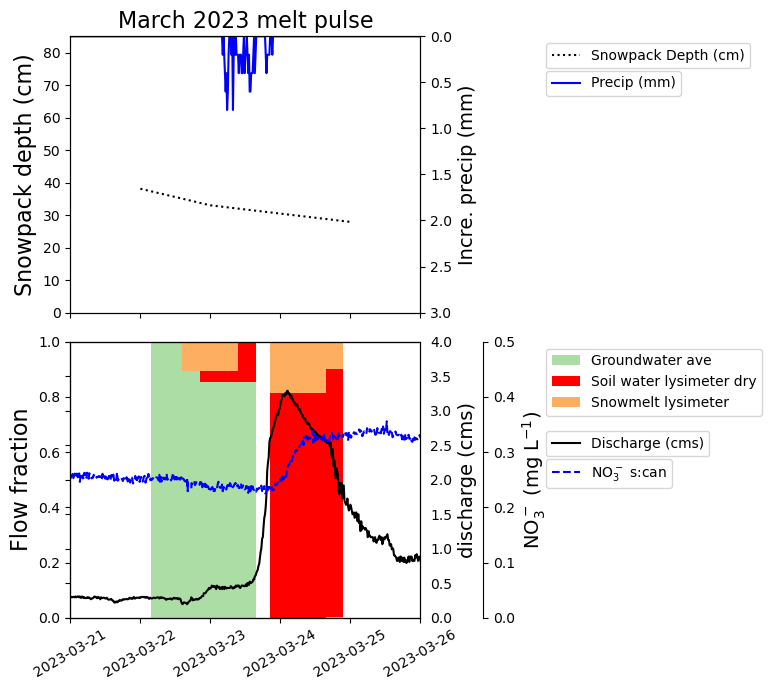

In [3]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
#Month = 'February'
Month = 'March'
#Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave
em_data = em_data[~em_data['Type'].isin(['Snowmelt lysimeter 2/15'])] #

# Load q and s::can NO3 + TP data from csv
scan_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)

# Load soil temperature data from csv
soil_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/EMMA/data/soil-sensor/Temperature.SoilTemp_15cm@HD_pit1.20210801.csv")

# Convert the timezone-aware datetime to timezone-naive
soil_data['ISO 8601 UTC'] = pd.to_datetime(soil_data['ISO 8601 UTC']).dt.tz_convert(None)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS VT-FR-30 station also on Amidon Rd
snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['datetime'], format="%Y-%m-%d", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits
start_A = pd.to_datetime("2023-02-08 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits
start_D = pd.to_datetime("2023-03-30 00:00:00")
end_D = pd.to_datetime("2023-04-12 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#abdda4', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater ave': '#abdda4', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater': '#abdda4', \
          'Soil water lysimeter wet': '#fa9fb5', \
          'Soil water lysimeter dry': 'red',\
          'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61',\
          'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, scan_data, snowpack_data, figsize=(9, 7)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['Datetime'] >= start) & (snowpack_data['Datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['Datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 16)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 14)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.9))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('March 2023 melt pulse', fontsize = 16)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.34, 1))

    ### Bottom subplot: Flow fractions ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=16)
    ax2.set_xlim([start, end])
    ax2.set_ylim(0,1)
    ax2.legend(loc='upper left', bbox_to_anchor=(1.34, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge and nitrate
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('discharge (cms)', color='black', fontsize = 14)
    ax2_secondary.set_ylim(0,4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.7))
    
    # Tertiary y-axis for nitrate
    ax2_tertiary = ax2_secondary.twinx()
    ax2_tertiary.spines.right.set_position(("axes", 1.18))
    ax2_tertiary.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='NO$_3^-$ s:can', linestyle='--')
    ax2_tertiary.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 14)
    ax2_tertiary.set_ylim(0,0.5)
    ax2_tertiary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.6))
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax2_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Final adjustments and show plot
    plt.tight_layout()
    plt.show()

plot_event_with_snowpack(eventC_df, "Event C (Mar 22-26, 2023)", \
                         colors_C, start_C, end_C, scan_data, snowpack_data)

## Event C: March melt residuals

## Event D: April freshet EMMA

Tracers are ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L'].


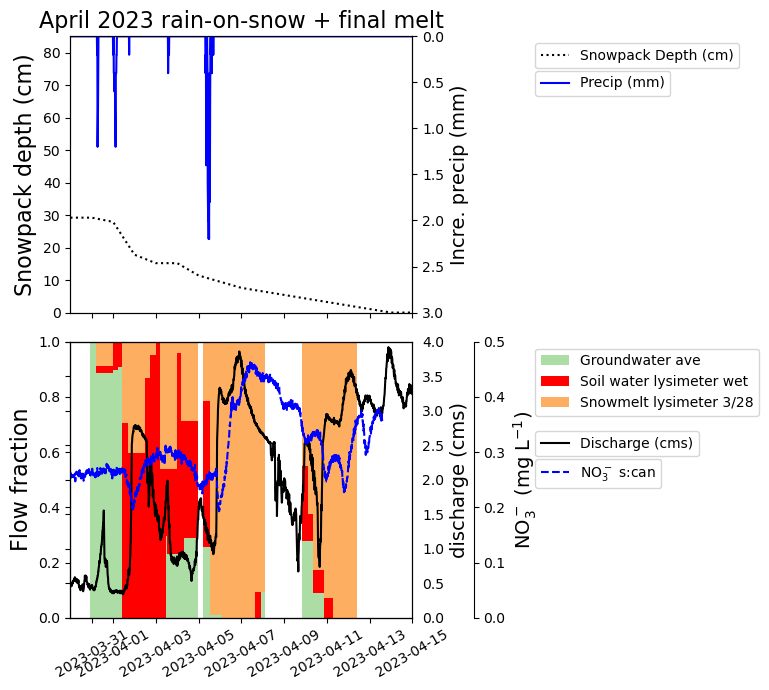

In [4]:
###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

#################################
# Set site, tracers, endmembers #
#################################

Site = 'Wade'
#Month = 'February'
#Month = 'March'
Month = 'April'

# Tracers

if Site == 'Hungerford':
    tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']
    
if Site == 'Wade':
    tracers = ['Ca_mg_L', 'dD', 'd18O', 'Na_mg_L', 'Mg_mg_L']
    
print(f"Tracers are {tracers}.")

# Endmembers
if Month == 'February':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-wade.csv") #EventAB
    
if Month == 'March':
    em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-wade.csv") #Event C
    
if Month == 'April':
    em_data = em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-wade.csv") #Event D
    

###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Wade' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == Site) & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # If excluding pre-event
em_data = em_data[~em_data['Type'].isin(['Groundwater Bear Pond'])] # If using GW ave at Wade
em_data = em_data[~em_data['Type'].isin(['Groundwater High Pond'])] # If using GW ave at Wade
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter wet'])] # If using ave
#em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter dry'])] # If using ave
em_data = em_data[~em_data['Type'].isin(['Precip'])] #
em_data = em_data[~em_data['Type'].isin(['Snowmelt lysimeter'])] #

# Load q and s::can NO3 + TP data from csv
scan_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/millar2021_R_separation_hysteresis/sonya-may24/data/wb_q_chem.csv")

# Convert the timezone-aware datetime to timezone-naive
scan_data['datetime'] = pd.to_datetime(scan_data['datetime']).dt.tz_convert(None)

# Load soil temperature data from csv
soil_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/EMMA/data/soil-sensor/Temperature.SoilTemp_15cm@HD_pit1.20210801.csv")

# Convert the timezone-aware datetime to timezone-naive
soil_data['ISO 8601 UTC'] = pd.to_datetime(soil_data['ISO 8601 UTC']).dt.tz_convert(None)

# Load snowpack depth data from Mt Mansfield snow stake
#snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/snowpack/data/mansfield-noaa-WY22-WY23-3855342.csv")
#snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['DATE'], format="%Y-%m-%d %H:%M", errors="coerce")

# Load snowpack depth data from CoCoRaHS VT-FR-30 station also on Amidon Rd
snowpack_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/LCBP_Soils/CleanedData/met-station/clean-cocorahs-vt-fr-30-20221115-20250414.csv")
snowpack_data['Datetime'] = pd.to_datetime(snowpack_data['datetime'], format="%Y-%m-%d", errors="coerce")

# Load met data including precip
met_data = pd.read_csv("/home/millieginty/OneDrive/git-repos/cQ_analysis/baseflow-rules-determinaton/data/wade_2020-2024_met_2024-11-08.csv")
met_data['Datetime'] = pd.to_datetime(met_data['Timestamp'], format = "%Y-%m-%d %H:%M:%S", errors = 'coerce')
met_data = met_data[met_data['Precip_Increm'].notna()] # Lots of missing (NA) precip in WWY23

#########
# PCA  #
#########

# Select the specific parameters from Site section (tracers)
selected_parametesr = tracers

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + tracers]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=tracers)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[tracers]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[tracers]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)

#######################
# VISUALIAZE THE EMMA #
#######################

# Filter data for samples in Event A
eventA_df = fractions_df[(fractions_df['Datetime'] >= '02/09/2023 00:00') \
                         & (fractions_df['Datetime'] <= '02/18/2023 00:00')]

#eventA_range = # Set x-axis limits
start_A = pd.to_datetime("2023-02-08 00:00:00")
end_A = pd.to_datetime("2023-02-20 00:00:00")

# Filter data for samples in Event C
eventC_df = fractions_df[(fractions_df['Datetime'] >= '03/21/2023 00:00') \
                         & (fractions_df['Datetime'] <= '03/26/2023 00:00')]

#eventC_range = # Set x-axis limits
start_C = pd.to_datetime("2023-03-21 00:00:00")
end_C = pd.to_datetime("2023-03-26 00:00:00")

# Filter data for samples in Event D
eventD_df = fractions_df[(fractions_df['Datetime'] >= '03/30/2023 00:00') \
                         & (fractions_df['Datetime'] <= '04/12/2023 00:00')]

#eventD_range = # Set x-axis limits
start_D = pd.to_datetime("2023-03-30 00:00:00")
end_D = pd.to_datetime("2023-04-15 00:00:00")

# Set 'Datetime' as the index
eventA_df.set_index('Datetime', inplace=True)
eventC_df.set_index('Datetime', inplace=True)
eventD_df.set_index('Datetime', inplace=True)

# Define colors for each endmember
colors_A = {'Groundwater ave': '#abdda4', \
          #'Soil water lysimeter wet': '#fa9fb5', \
          #'Soil water lysimeter dry': 'red',\
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}#,\
          #'Pre-event': '#3182bd'}

# Define colors for each endmember
colors_C = {'Groundwater ave': '#abdda4', \
          'Soil water lysimeter dry': 'red',\
          'Snowmelt lysimeter': '#fdae61'}\
          #'Pre-event': '#3182bd' }

# Define colors for each endmember
colors_D = {'Groundwater ave': '#abdda4', \
          'Soil water lysimeter wet': 'red', \
          #'Soil water lysimeter dry': 'red',\
          #'Precip': '#3182bd',\
          'Snowmelt lysimeter 3/28': '#fdae61'}#,\
          #'Snowmelt lysimeter 4/12': '#ffeda0'}\
          #'Pre-event': '#3182bd' }

def plot_event_with_snowpack(
    event_df, event_name, colors, start, end, scan_data, snowpack_data, figsize=(9, 7)
):
    """
    Creates two stacked subplots:
    - Top: Snowpack depth and (eventually) rainfall data with two y-axes.
    - Bottom: Flow fractions, discharge, and nitrate.

    Parameters:
    - event_df: DataFrame containing data for the event, with Datetime as the index.
    - event_name: Name of the event (str) to use in the plot title.
    - colors: Dictionary mapping endmembers to colors.
    - start: Start datetime for the event.
    - end: End datetime for the event.
    - scan_data: DataFrame containing discharge and nitrate data.
    - snowpack_data: DataFrame containing snowpack depth data.
    - figsize: Tuple specifying figure size.
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)

    ### Top subplot: Snowpack and eventually rainfall ###
    # Filter snowpack + rainfall data for the event duration
    snowpack_event = snowpack_data[(snowpack_data['Datetime'] >= start) & (snowpack_data['Datetime'] <= end)]
    precip_event = met_data[(met_data['Datetime'] >= start) & (met_data['Datetime'] <= end)]

    # Plot snowpack data on the primary y-axis
    ax1.plot(snowpack_event['Datetime'], snowpack_event['snowpack_cm'], color='black', label='Snowpack Depth (cm)', linestyle=':')
    ax1.set_ylabel('Snowpack depth (cm)', color='black', fontsize = 16)
    ax1.set_ylim([0, 85])
    ax1.tick_params(axis='y', labelcolor='black')

    # Create a secondary y-axis for rainfall
    ax1_secondary = ax1.twinx()
    ax1_secondary.plot(met_data['Datetime'], met_data['Precip_Increm'], color='blue', label='Precip (mm)')
    ax1_secondary.invert_yaxis()
    ax1_secondary.set_ylim([3, 0])
    ax1_secondary.set_ylabel('Incre. precip (mm)', color='black', fontsize = 14)
    ax1_secondary.tick_params(axis='y', labelcolor='black')
    ax1_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.9))

    # Set labels and legend
    #ax1.set_title(f'Snowpack depth and rainfall during {event_name}')
    ax1.set_title('April 2023 rain-on-snow + final melt', fontsize = 16)
    ax1.legend(loc='upper left', bbox_to_anchor=(1.34, 1))

    ### Bottom subplot: Flow fractions ###
    bottom = None
    for column, color in colors.items():
        ax2.bar(event_df.index, event_df[column], label=column, color=color, bottom=bottom)
        if bottom is None:
            bottom = event_df[column].values
        else:
            bottom += event_df[column].values

    #ax2.set_xlabel('Datetime')
    ax2.set_xlabel('')
    ax2.set_ylabel('Flow fraction', fontsize=16)
    ax2.set_xlim([start, end])
    ax2.legend(loc='upper left', bbox_to_anchor=(1.34, 1))
    #ax2.set_title(f'Fractional endmember contributions during {event_name}')
    ax2.tick_params(axis='x', rotation=30)

    # Secondary y-axis for discharge and nitrate
    ax2_secondary = ax2.twinx()
    ax2_secondary.plot(scan_data['datetime'], scan_data['q_cms_wb'], color='black', label='Discharge (cms)', linestyle='-')
    ax2_secondary.set_ylabel('discharge (cms)', color='black', fontsize = 14)
    ax2_secondary.set_ylim(0,4)
    ax2_secondary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.7))
    
    # Tertiary y-axis for nitrate
    ax2_tertiary = ax2_secondary.twinx()
    ax2_tertiary.spines.right.set_position(("axes", 1.18))
    ax2_tertiary.plot(scan_data['datetime'], scan_data['NO3'], color='blue', label='NO$_3^-$ s:can', linestyle='--')
    ax2_tertiary.set_ylabel('NO$_3^-$ (mg L$^{-1}$)', color='black', fontsize = 14)
    ax2_tertiary.set_ylim(0,0.5)
    ax2_tertiary.legend(loc='upper left', bbox_to_anchor=(1.34, 0.6))
    
    # Fix secondary y-axis tick alignment after creating the tertiary axis
    ax2_secondary.tick_params(axis='y', labelright=True, labelleft=False)

    # Final adjustments and show plot
    plt.tight_layout()
    plt.show()

plot_event_with_snowpack(eventD_df, "Event D (Mar 30 - Apr 12, 2023)", \
                         colors_D, start_D, end_D, scan_data, snowpack_data)

#plot_event_with_snowpack.savefig("/home/millieginty/Desktop/Wade_EMMA_D.png")

## Calculating and plotting EMMA residuals

Residuals for each sample-tracer pair:
 [[ 5.93722360e-01  1.23727588e+00]
 [ 6.65946308e-01  1.36892960e+00]
 [ 3.77769766e-01  7.87707940e-01]
 [-1.70475263e-06  6.69089348e-06]
 [-1.47400987e+00  8.18449085e-02]
 [-6.45647136e-04  7.23767468e-03]
 [-2.06580781e-02  2.31065859e-01]
 [-2.71042762e-06 -2.14125619e-06]
 [ 3.84796570e-02 -3.12823153e-01]
 [ 3.63361475e-02 -2.95337416e-01]
 [ 7.37676484e-03 -6.03116271e-02]
 [ 1.98571752e-02 -1.61258020e-01]
 [-3.65407626e-08 -3.67124268e-06]
 [-4.56589697e-07 -5.73460455e-06]
 [-1.05951546e+00  3.28320646e-01]
 [-8.37287373e-01  4.11413134e-01]
 [-3.54473441e-01  1.74300248e-01]
 [-1.57345852e-02  7.77352955e-03]
 [ 8.70246339e-07  3.07041609e-06]
 [ 2.88874548e-06  4.09814738e-06]
 [ 1.67047178e-06  4.11240173e-06]
 [ 1.83118185e-06 -5.08246970e-06]
 [-1.09815130e-06 -6.10578248e-06]
 [-5.04331649e-02  2.48002892e-02]
 [ 1.15786490e-01 -9.40984039e-01]]
Mean Absolute Residual: 0.24198940464096658
Sum of Absolute Residuals: 12.0994702320

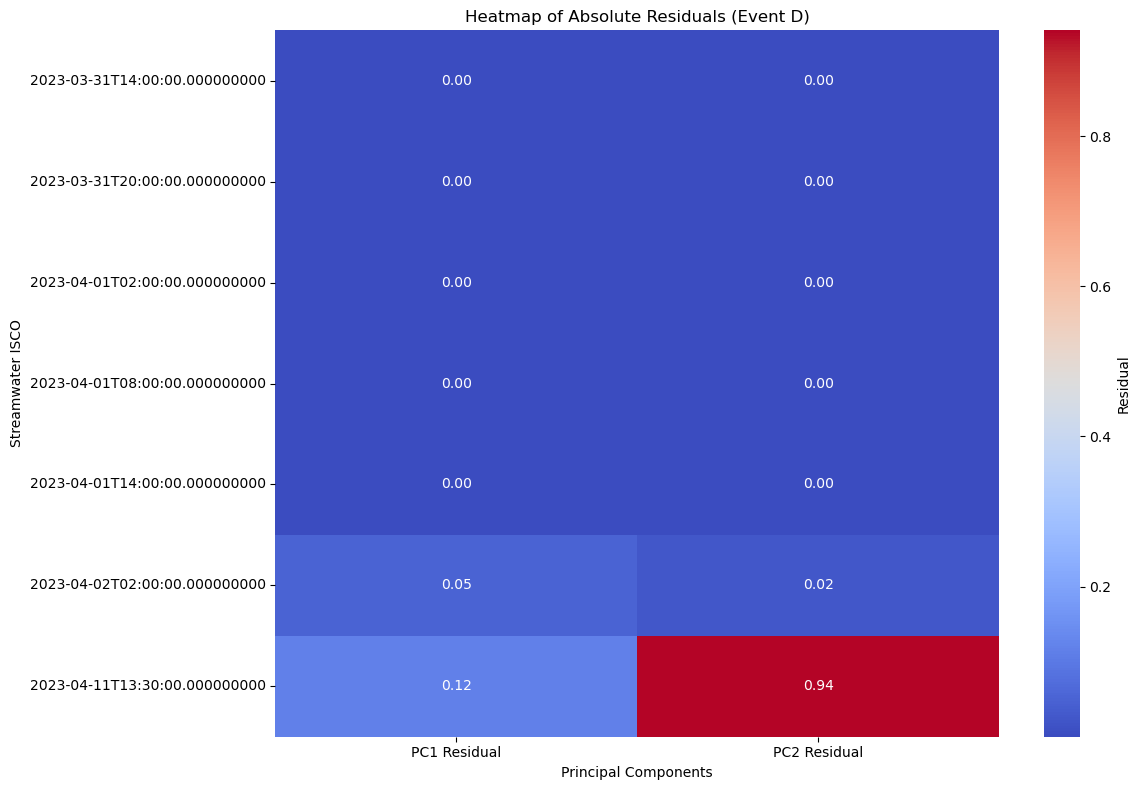

In [5]:
## EMMA residuals

###################
# SET LIBRARIES #
###################

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns # for residuals heatmap


###################################################
# Load + clean the streamwater and endmember data #
###################################################

# Load the streamwater and endmember data from the joined RI series CSV file
data = pd.read_csv("isco_metadata/LCBP_RI_sample_index/RI23-IC-ICP-isotope-joined.csv")
data['Datetime'] = (data['Date'] + ' ' + data['Time'])
data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
data = data[data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune

# Filter for 'Hungerford' sites and specific sample types
streamwater_data = data.loc[
    (data['Site'] == "Hungerford") & 
    (data['Type'].isin(['Grab', 'Grab/Isco', 'Baseflow']))
]

# Load the month-specific endmember data from the CSV file
em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-february-hford.csv") #EventAB
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-march-hford.csv") #Event C
#em_data = pd.read_csv("data/newrnet-chemistry/RI23-endmembers-april-hford.csv") #Event D

em_data['Datetime'] = (em_data['Date'] + ' ' + em_data['Time'])
em_data['Datetime'] = pd.to_datetime(em_data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce")
em_data = em_data[em_data['Datetime'].notna()] # NA dates (we have a couple) not useful - prune
em_data = em_data[~em_data['Type'].isin(['Pre-event'])] # I only kept pre-event in these csvs for PCAs
em_data = em_data[~em_data['Type'].isin(['Soil water lysimeter ave'])] # Ave of soil water EMs

#########
# PCA  #
#########

# Select the specific parameters of interest
selected_parameters = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L']

# Preserve identifying columns (Type, Date, Time, Datetime)
identifying_columns = ['Sample ID', 'Site', 'Type', 'Datetime']
subset_streamwater = streamwater_data[identifying_columns + selected_parameters]

# Drop rows with NaN in the selected parameters (this prunes rows only for PCA and keeps identifying info)
subset_streamwater = subset_streamwater.dropna(subset=selected_parameters)

# Extract numeric tracer data for PCA
numeric_streamwater = subset_streamwater[selected_parameters]

# Standardize the streamwater data (mean=0 and variance=1)
scaler = StandardScaler()
scaled_streamwater = scaler.fit_transform(numeric_streamwater)

# Apply PCA to streamwater data
pca_streamwater = PCA(n_components=2)
pca_result_streamwater = pca_streamwater.fit_transform(scaled_streamwater)

# Save the PCA results for EMMA later
pcs = ["Principal Component 1", "Principal Component 2"]
pca_2Dresult_streamwater = pd.DataFrame(pca_result_streamwater, columns=pcs)

# Attach identifying columns back to PCA results
pca_2Dresult_streamwater = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), 
                                      pca_2Dresult_streamwater], axis=1)

# PCA for endmembers
subset_endmembers = em_data[selected_parameters]
scaler = StandardScaler()
scaled_endmembers = scaler.fit_transform(subset_endmembers)
pca_endmembers = PCA(n_components=2)
pca_result_endmembers = pca_endmembers.fit_transform(scaled_endmembers)

#########
# EMMA  #
#########

# Function to calculate the linear optimization objective function
def objective_function(Ii, xi, B):
    xi_pred = np.dot(Ii, B)
    return np.linalg.norm(xi - xi_pred)

# Constraints
constraints = ({'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},  # Sum of fractions is 1
               {'type': 'ineq', 'fun': lambda Ii: Ii},  # Fractions are non-negative
               {'type': 'ineq', 'fun': lambda Ii: 1 - Ii})  # Fractions are less than or equal to 1

fractions = []
for i in range(len(pca_result_streamwater)):
    # Extract PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :].reshape(1, -1)

    # Initialize fractions with equal weights
    initial_guess = np.ones(pca_result_endmembers.shape[0]) / pca_result_endmembers.shape[0]

    # Optimization to find fractions using SciPy sequential least squares quadratic programming
    result = minimize(objective_function, initial_guess, args=(pca_vector_streamwater, pca_result_endmembers),
                      constraints=constraints, method='SLSQP')

    # Append the fractions for the current observation
    fractions_i = result.x
    fractions.append(fractions_i)

# Stack fractions into a numpy array
fractions = np.vstack(fractions)

# Create a DataFrame with the fraction information
fractions_df = pd.DataFrame(fractions, columns=em_data['Type'])

# Attach identifying information back to fractions DataFrame
fractions_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), fractions_df], axis=1)

# Optionally, calculate the sum of fractions (on numeric columns only)
fractions_df['Sum Fractions'] = fractions_df[em_data['Type']].sum(axis=1)


# Function to calculate residuals
def calculate_residuals(I, B, xi):
    # Calculate predicted values
    xi_pred = np.dot(I, B)
    # Calculate residuals
    residuals = xi - xi_pred
    return residuals, np.abs(residuals)  # Return both residuals and absolute residuals

# Residuals storage
all_residuals = []
absolute_residuals = []

# Iterate over all streamwater samples
for i in range(len(pca_result_streamwater)):
    # Extract observed PCA vector for the current streamwater sample
    pca_vector_streamwater = pca_result_streamwater[i, :]

    # Extract mixing fractions for this sample
    fractions_i = fractions[i, :]

    # Calculate residuals for the current sample
    residual, abs_residual = calculate_residuals(fractions_i, pca_result_endmembers, pca_vector_streamwater)

    # Append to the list
    all_residuals.append(residual)
    absolute_residuals.append(abs_residual)

# Convert residuals to numpy arrays
all_residuals = np.array(all_residuals)
absolute_residuals = np.array(absolute_residuals)

# Compute total residuals across all tracers and samples
mean_residual = np.mean(absolute_residuals)
sum_residual = np.sum(absolute_residuals)

# Print results
print("Residuals for each sample-tracer pair:\n", all_residuals)
print("Mean Absolute Residual:", mean_residual)
print("Sum of Absolute Residuals:", sum_residual)

# Convert absolute residuals to a DataFrame for better labeling
residuals_df = pd.DataFrame(
    absolute_residuals,
    columns=["PC1 Residual", "PC2 Residual"],
    index=[f"Sample {i+1}" for i in range(absolute_residuals.shape[0])]
)

# Plot heatmap

# Add identifying columns to residuals
residuals_df = pd.DataFrame(
    absolute_residuals,
    columns=["PC1 Residual", "PC2 Residual"]
)
residuals_df = pd.concat([subset_streamwater[identifying_columns].reset_index(drop=True), residuals_df], axis=1)


# Set 'Sample ID' as the index for better labeling in the heatmap
residuals_df.set_index('Datetime', inplace=True)

# Ensure 'Datetime' is in datetime format (already the index here)
residuals_df.index = pd.to_datetime(residuals_df.index)

# Filter for the desired date range
filtered_residuals_df = residuals_df.loc["2023-03-28":"2023-04-20"]

# Plot heatmap for the filtered date range
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_residuals_df[["PC1 Residual", "PC2 Residual"]], annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Residual"})
plt.title("Heatmap of Absolute Residuals (Event D)")
plt.ylabel("Streamwater ISCO")
plt.xlabel("Principal Components")
plt.tight_layout()
plt.show()